I was assigned the following mandatory tasks :
- Task  1: Top Selling Department
	Chart of number of products sold by department
- Task  2: How Often are Products Reorder?
	Chart showing reordered/not-reordered products.
- Task  3: Most Often Reordered Products 
	Which products are reordered most often and which probability?
- Task  4: How are Aisles Organized Within Departments?
	Multi-chart showing distribution of products on aisles for various departments.
- Task  5: How many Distinct Product do Customers Buy? 
	Chart of distribution of number of unique products in a customers history.
    
However there was some overlap with my EDA, some of which has been included in this notebook (listed below) and others which are included in other notebooks (such as looking at the relationship between add to cart order and product importance in the classification notebook)

- Number of Products by Department
- Department Size vs Sales
- Number of Times Reordered
- Number of Products by Aisle   
- Customer with the Most Reordering
- Customer Reorder Rate

# imports

In [1]:
%matplotlib inline 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("paper")
from itertools import combinations, groupby
from collections import Counter
import sys
from collections import Counter


# Create dataframes

In [2]:
orders_products_prior_full = pd.read_csv('instacart_2017_05_01/my_order_products__prior.csv')
orders_products_train_full = pd.read_csv('instacart_2017_05_01/my_order_products__train.csv')
orders_products = pd.concat([orders_products_prior_full, orders_products_train_full])
print("Combined data row count : {}".format(len(orders_products)))
orders = pd.read_csv('instacart_2017_05_01/my_orders.csv')
products = pd.read_csv('instacart_2017_05_01/products.csv')
aisles = pd.read_csv('instacart_2017_05_01/aisles.csv')
departments = pd.read_csv('instacart_2017_05_01/departments.csv')

orders_a = pd.merge(orders, orders_products, on='order_id', how='inner').apply(lambda x: x)
columns = ['order_id', 'user_id', 'days_since_prior_order', 'product_id']
raw_data = pd.DataFrame(orders_a, columns=columns)
raw_data = pd.merge(raw_data, products, on='product_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, aisles, on='aisle_id', how='left').apply(lambda x: x)
raw_data = pd.merge(raw_data, departments, on='department_id', how='left').apply(lambda x: x)
master_df = raw_data.copy()
print("Combined data row count : {}".format(len(master_df)))
master_df.head()

Combined data row count : 2374
Combined data row count : 2374


,order_id,user_id,days_since_prior_order,product_id,product_name,aisle_id,department_id,aisle,department
0,3308693,1886,NaN,42972,Natural Pure Sparkling Water,115,7,water seltzer sparkling water,beverages
1,3308693,1886,NaN,47977,Grapefruit Sparkling Water,115,7,water seltzer sparkling water,beverages
2,3308693,1886,NaN,30696,Eggo Homestyle Waffles,52,1,frozen breakfast,frozen
3,1019221,1886,6.0,9623,Sparkling Natural Spring Water,115,7,water seltzer sparkling water,beverages
4,1019221,1886,6.0,35914,Dha Omega 3 Reduced Fat 2% Milk,84,16,milk,dairy eggs


# utility methods

In [3]:
#https://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b


# Task 1: Top Selling Department 
Chart of number of products sold by department
DISCLAIMER : Only including products that have been ordered at least once and departments that have sold products

## OPTIONAL TASK: Number of Products by Department
Chart of number of products in stock by department

## OPTIONAL TASK: Department Size vs Sales
Graph showin ranking of department size (number of product) vs sales ranking

In [4]:
print("{} unique departments -> {} unique groups"
      .format(len(master_df["department_id"].unique()),len(master_df.groupby("department_id").size())))

df_dept_stats = pd.DataFrame(master_df.groupby("department_id").size().reset_index(name="order_count"))
print("Total number of products sold across departments : {}".format(df_dept_stats["order_count"].sum()))
print("The average number of orders per department is : {}".format(round(df_dept_stats["order_count"].mean())))

mylist = []
for dept_id in master_df["department_id"].unique():
    mylist.append(master_df.loc[master_df['department_id'] == dept_id]["product_id"].nunique())


df_dept_stats["product_count"] = mylist
print("Total number of unique products sold across departments : {}".format(df_dept_stats["product_count"].sum()))
print("The average number of unique products per department is : {}".format(round(df_dept_stats["product_count"].mean())))
total_order_count = df_dept_stats["order_count"].sum()
total_product_count = df_dept_stats["product_count"].sum()
df_dept_stats["orders_pct"] = df_dept_stats["order_count"]/total_order_count
df_dept_stats["product_pct"] = df_dept_stats["product_count"]/total_product_count
df_dept_stats = df_dept_stats.set_index("department_id").join(departments.set_index("department_id"), how="inner").sort_values(by="order_count", ascending=False)
df_dept_stats.head(n=10)

18 unique departments -> 18 unique groups
Total number of products sold across departments : 2374
The average number of orders per department is : 132
Total number of unique products sold across departments : 876
The average number of unique products per department is : 49


,order_count,product_count,orders_pct,product_pct,department
department_id,,,,,
4,623,128,0.262426,0.146119,produce
16,452,32,0.190396,0.036530,dairy eggs
19,295,22,0.124263,0.025114,snacks
7,220,17,0.092671,0.019406,beverages
13,146,106,0.061500,0.121005,pantry
3,102,48,0.042965,0.054795,bakery
1,95,77,0.040017,0.087900,frozen
20,86,18,0.036226,0.020548,deli
15,59,31,0.024853,0.035388,canned goods


Top ten departments by order count : ['produce' 'dairy eggs' 'snacks' 'beverages' 'pantry' 'bakery' 'frozen'
 'deli' 'canned goods' 'breakfast']
Top ten departments by product count : ['bulk' 'produce' 'international' 'pantry' 'frozen' 'bakery' 'breakfast'
 'dairy eggs' 'canned goods' 'meat seafood']
Top selling department is produce
Department with most products is bulk


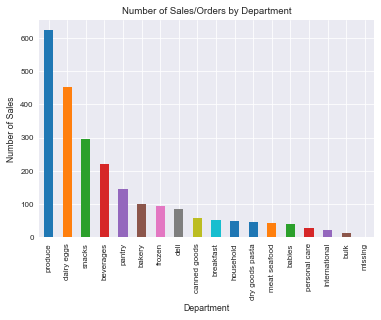

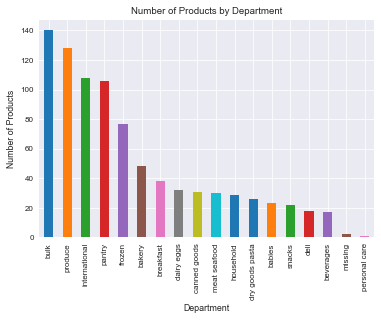

best fit line:
y = 84.40 + 0.98x


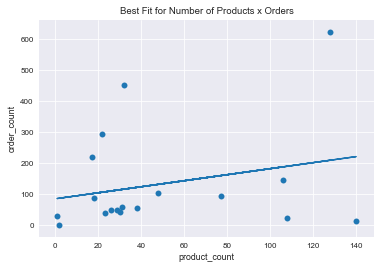

In [5]:

tt_orders = df_dept_stats.sort_values(by="order_count",ascending=False).head(n=10)["department"].values
print ("Top ten departments by order count : {}"
    .format(tt_orders))

tt_prods = df_dept_stats.sort_values(by="product_count",ascending=False).head(n=10)["department"].values
print ("Top ten departments by product count : {}"
    .format(tt_prods))

print("Top selling department is {}".format(tt_orders[0]))
print("Department with most products is {}".format(tt_prods[0]))

fig, ax = plt.subplots()
df_dept_stats.sort_values(by="order_count",ascending=False)['order_count'].plot.bar();
ax.set_xticklabels(df_dept_stats.sort_values(by="order_count",ascending=False)['department'])
plt.title("Number of Sales/Orders by Department")
plt.ylabel("Number of Sales")
plt.xlabel("Department")
plt.show()

fig, ax = plt.subplots()
df_dept_stats.sort_values(by="product_count",ascending=False)['product_count'].plot.bar();
ax.set_xticklabels(df_dept_stats.sort_values(by="product_count",ascending=False)['department'])
plt.title("Number of Products by Department")
plt.ylabel("Number of Products")
plt.xlabel("Department")
plt.show()


df_dept_stats.plot(kind='scatter', x='product_count', y='order_count')
X = df_dept_stats["product_count"]
Y = df_dept_stats["order_count"]
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.title("Best Fit for Number of Products x Orders")
plt.plot(X, yfit)


# Task 2: Most Often Reordered Products 
Which products are reordered most often and which probability

## OPTIONAL TASK: Number of Times Reordered
Graph of number of products vs number of times reordered.

In [6]:

df = pd.DataFrame(orders_products.groupby("product_id").size().reset_index(name="total_count"))
reordered_df = orders_products.loc[orders_products['reordered'] == 1]
reordered_stats = pd.DataFrame(reordered_df.groupby("product_id").size().reset_index(name="reorder_count")).sort_values("reorder_count",ascending=False)
reordered_stats = reordered_stats.set_index("product_id").join(products.set_index("product_id"))
reordered_stats = reordered_stats.join(df.set_index("product_id"))
reordered_stats["prob_of_reorder"] = reordered_stats["reorder_count"]/reordered_stats["total_count"]*100
print("Top ten most reordered products are {}".format(reordered_stats["product_name"][:10].values))
print("Most reordered product is {} with a reorder probability of {}%"
      .format(reordered_stats["product_name"][:1].values[0],round(reordered_stats["prob_of_reorder"][:1].values[0])))
reordered_stats.head(n=10)

Top ten most reordered products are ['Banana' 'Bag of Organic Bananas' 'Natural Pure Sparkling Water'
 'Apple Honeycrisp Organic' 'Organic Half & Half' 'Hass Avocados'
 'Peach Yoghurt' 'Organic Avocado' 'Organic Reduced Fat 2% Milk'
 'Organic Greek Lowfat Yogurt With Cherries']
Most reordered product is Banana with a reorder probability of 92.0%


,reorder_count,product_name,aisle_id,department_id,total_count,prob_of_reorder
product_id,,,,,,
24852,58,Banana,24,4,63,92.063492
13176,25,Bag of Organic Bananas,24,4,31,80.645161
42972,24,Natural Pure Sparkling Water,115,7,25,96.000000
8277,22,Apple Honeycrisp Organic,24,4,23,95.652174
49235,20,Organic Half & Half,53,16,24,83.333333
12341,18,Hass Avocados,32,4,20,90.000000
17183,18,Peach Yoghurt,120,16,19,94.736842
47766,17,Organic Avocado,24,4,21,80.952381
5785,17,Organic Reduced Fat 2% Milk,84,16,19,89.473684


Top five products by reorder count : ['Banana' 'Bag of Organic Bananas' 'Natural Pure Sparkling Water'
 'Apple Honeycrisp Organic' 'Organic Half & Half']


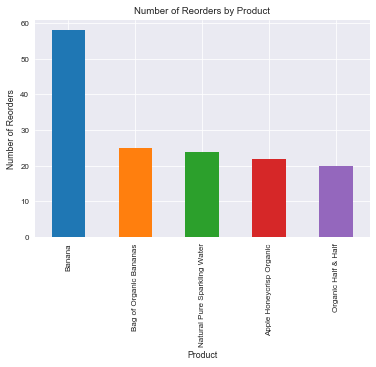

In [7]:
print ("Top five products by reorder count : {}"
    .format(reordered_stats.sort_values(by="reorder_count",ascending=False).head(n=5)["product_name"].values))

fig, ax = plt.subplots()
reordered_stats.sort_values(by="reorder_count",ascending=False).head(n=5).sort_values(by="reorder_count",ascending=False)['reorder_count'].plot.bar();
ax.set_xticklabels(reordered_stats.sort_values(by="reorder_count",ascending=False).head(n=5)['product_name'])
plt.title("Number of Reorders by Product")
plt.ylabel("Number of Reorders")
plt.xlabel("Product")
plt.show()




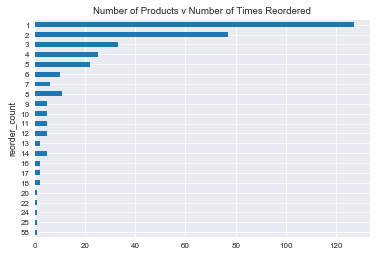

In [8]:

rows = []
for k,v in Counter(reordered_stats["reorder_count"]).items():
    row ={}
    row["count"] = k
    row["reorders"] = v
    rows.append(row)
    
df = pd.DataFrame(rows)
df.columns = ["reorder_count","product_count"]
df.set_index("reorder_count").plot(kind="barh", title="Number of Products v Number of Times Reordered",legend=False)




In [9]:
reordered_product_ids = reordered_stats.index.values

no_reorders_df = orders_products.loc[(orders_products['reordered'] == 0)]

no_reorders_df = no_reorders_df[~no_reorders_df['product_id'].isin(reordered_product_ids)] #don't include items that have been reordered
no_reorders_stats = pd.DataFrame(no_reorders_df.groupby("product_id").size().reset_index(name="order_count")).sort_values("order_count",ascending=False)
no_reorders_stats = no_reorders_stats.set_index("product_id").join(products.set_index("product_id"))
no_reorders_stats.head(n=10)

,order_count,product_name,aisle_id,department_id
product_id,,,,
34126,3,Organic Italian Parsley Bunch,16,4
4799,3,Shredded Parmesan,21,16
40706,3,Organic Grape Tomatoes,123,4
30450,3,Creamy Almond Butter,88,13
46473,2,Pure Vanilla Extract,17,13
46979,2,Asparagus,83,4
24390,2,Pomegranate,24,4
11182,2,Baby Spinach,123,4
22474,2,Cheddar Bunnies Snack Crackers,78,19


Worst five products by reorder count : ['Organic Italian Parsley Bunch' 'Creamy Almond Butter'
 'Shredded Parmesan' 'Organic Grape Tomatoes' 'Organic Ketchup']


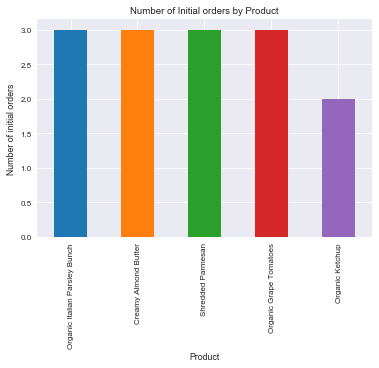

In [10]:
print ("Worst five products by reorder count : {}"
    .format(no_reorders_stats.sort_values(by="order_count",ascending=False).head(n=5)["product_name"].values))

fig, ax = plt.subplots()
no_reorders_stats.sort_values(by="order_count",ascending=False).head(n=5).sort_values(by="order_count",ascending=False)['order_count'].plot.bar();
ax.set_xticklabels(no_reorders_stats.sort_values(by="order_count",ascending=False).head(n=5)['product_name'])
plt.title("Number of Initial orders by Product")
plt.ylabel("Number of initial orders")
plt.xlabel("Product")
plt.show()

# Task 3: How Often are Products Reordered?
Chart showing reordered/not-reordered products (This task is continued / overlaps with Task 5 which shows what products are being reordered most/least)

876
527
Less than half (39.84%) of the products in this sample data set have been reorderd.


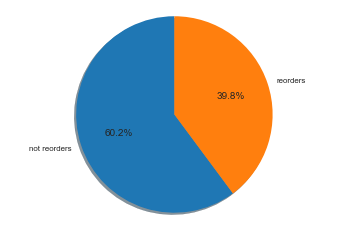

In [11]:
count_of_products_redordered = len(reordered_product_ids)
count_of_products_not_reordered = len(no_reorders_stats.index.values)
total_count_of_products_ordered = count_of_products_redordered + count_of_products_not_reordered
print(total_count_of_products_ordered)
print(count_of_products_not_reordered)

print ("Less than half ({:.2f}%) of the products in this sample data set have been reorderd."
    .format(count_of_products_redordered / total_count_of_products_ordered*100))

fig1, ax1 = plt.subplots()
labels = "not reorders","reorders"
sizes = [count_of_products_not_reordered, count_of_products_redordered]
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


# Task 4: How are Aisles Organized Within Departments? 
Multi-chart showing distribution of products on aisles for various departments.

## OPTIONAL TASK: Number of Products by Aisle
Chart of number of products in stock by aisle

In [12]:
aisles_and_products = products.groupby("aisle_id").size().reset_index(name="product_count")
aisles_and_products = (aisles_and_products
    .set_index('aisle_id').join(aisles.set_index('aisle_id'))
    .sort_values(by=['product_count']))

aisles_and_departments = (pd.merge(aisles_and_products.reset_index(),products, on="aisle_id")
       .drop(['product_id', 'product_name'], axis=1)
       .set_index("department_id").join(departments.set_index("department_id"))
       .drop_duplicates())

rows = []
for dept, group in aisles_and_departments.groupby("department"):
    row = {}
    row["department"] = dept
    row["aisles"] = len(group)
    row["products"] = group["product_count"].sum()
    row["label"] = "{} [{}]".format(dept,len(group))
    rows.append(row)
    
dap_df = pd.DataFrame(rows,columns=["department","aisles","products","label"]).sort_values(by="aisles", ascending=False)
dap_df.head()

,department,aisles,products,label
17,personal care,17,6563,personal care [17]
16,pantry,12,5371,pantry [12]
10,frozen,11,4007,frozen [11]
20,snacks,11,6264,snacks [11]
7,dairy eggs,10,3449,dairy eggs [10]


In [13]:
print("{} has the most aisles, selling {} product across {} aisles"
      .format(dap_df.head(n=1)["department"].values[0],dap_df.head(n=1)["products"].values[0],dap_df.head(n=1)["aisles"].values[0]))
dap_df.describe()

personal care has the most aisles, selling 6563 product across 17 aisles


,aisles,products
count,21.000000,21.000000
mean,6.380952,2366.095238
std,4.128876,1914.367491
min,1.000000,38.000000
25%,4.000000,1081.000000
50%,5.000000,1516.000000
75%,10.000000,3449.000000
max,17.000000,6563.000000


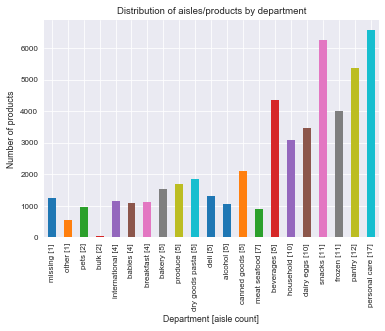

In [14]:

fig, ax = plt.subplots()
dap_df = dap_df.sort_values(by="aisles").set_index("aisles")
dap_df['products'].plot.bar();
ax.set_xticklabels(dap_df['label'])
plt.rcParams["figure.figsize"] = [12, 9] 
plt.title("Distribution of aisles/products by department")
plt.ylabel("Number of products")
plt.xlabel("Department [aisle count]")
plt.show()

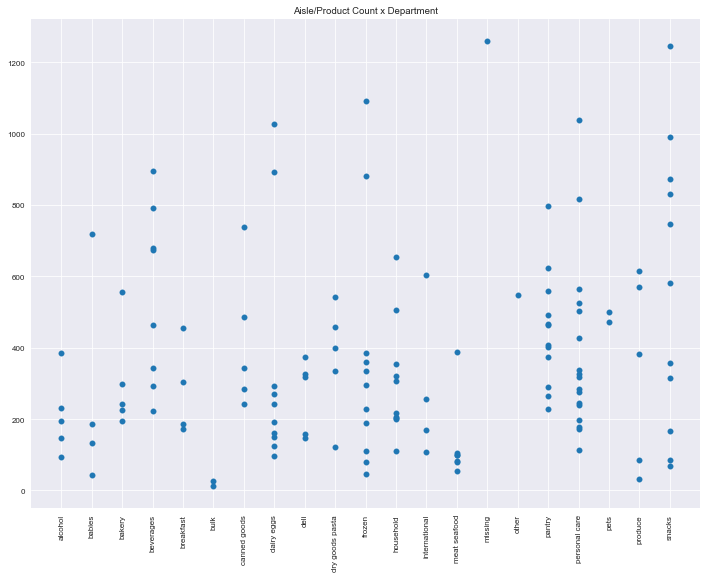

Top Five Aisles By Products In Stock : ['missing' 'candy chocolate' 'ice cream ice' 'vitamins supplements'
 'yogurt']


,aisle_id,product_count,aisle,department
department_id,,,,
21,100,1258,missing,missing
19,45,1246,candy chocolate,snacks
1,37,1091,ice cream ice,frozen
11,47,1038,vitamins supplements,personal care
16,120,1026,yogurt,dairy eggs


In [15]:
x = aisles_and_departments["department"]
y = aisles_and_departments["product_count"]
plt.rcParams["figure.figsize"] = [12, 9] 
plt.title("Aisle/Product Count x Department")
plt.xticks(rotation=90)
plt.scatter(x, y)
plt.show()
most_stocked_df = aisles_and_departments.sort_values(by="product_count",ascending=False)
print("Top Five Aisles By Products In Stock : {}".format(most_stocked_df["aisle"][0:5].values))
most_stocked_df.head()

### deep dive examples: alcohol and personal care

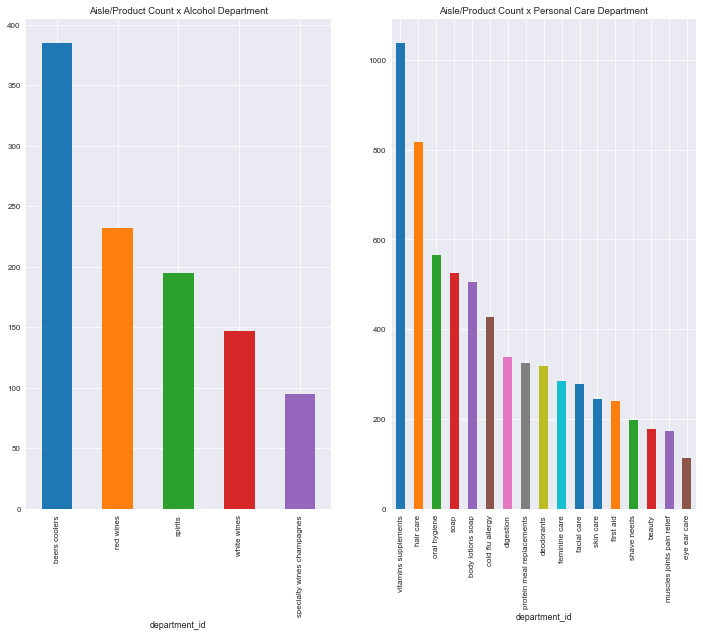

In [16]:

fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)

alcohol_df = aisles_and_departments[aisles_and_departments["department"] == "alcohol"].sort_values(by="product_count",ascending=False)
alcohol_df["product_count"].plot.bar();
ax1.set_xticklabels(alcohol_df["aisle"])
plt.title("Aisle/Product Count x Alcohol Department")

ax2 = fig.add_subplot(1, 2, 2)
df = aisles_and_departments[aisles_and_departments["department"] == "personal care"].sort_values(by="product_count",ascending=False)
df["product_count"].plot.bar();
ax2.set_xticklabels(df["aisle"])
plt.title("Aisle/Product Count x Personal Care Department")
plt.show()


# Task 5: How many Distinct Product do Customers Buy? 
Chart of distribution of number of unique products in a customers history

## OPTIONAL TASK: Customer with the Most Reordering
Chart of customers by percentage of products reordered with respect to total products ordered.

## OPTIONAL TASK: Customer Reorder Rate
Chart of distribution proportion of products reorder with respect to total products per customer

In [17]:

unique_users = master_df["user_id"].unique()
rows = []


for u in unique_users:
    row = {}
    products_ordered = master_df.loc[(master_df['user_id'] == u)]["product_name"]
    row["user_id"] = u
    #row["products_total"] = len(products_ordered)
    row["products_distinct"] = products_ordered.nunique()
    row["products_not_reordered"] = len([k for k, v in Counter(products_ordered.values).items() if v < 2])
    row["products_reordered"] = row["products_distinct"]-row["products_not_reordered"]
    row["reorder_pct"] = round((row["products_reordered"]/row["products_distinct"])*100)
    rows.append(row)

user_product_stats = pd.DataFrame(rows).set_index("user_id").sort_values(by="products_distinct",ascending=False) # Convert it back
dis_min = user_product_stats['products_distinct'].min()
dis_25 = round(user_product_stats['products_distinct'].quantile(0.25))
dis_med = round(user_product_stats['products_distinct'].median())
dis_75 = round(user_product_stats['products_distinct'].quantile(0.75))
dis_max = user_product_stats['products_distinct'].max()
q1 = "{}-{}".format(dis_min,dis_25)
q2 = "{}-{}".format(dis_25,dis_med)
q3 = "{}-{}".format(dis_med,dis_75)
q4 = "{}-{}".format(dis_75,dis_max)
user_product_stats['distinct_quartile'] = pd.qcut(user_product_stats['products_distinct'], 4, ['q1','q2','q3','q4'])
user_product_stats['quartile_info'] = pd.qcut(user_product_stats['products_distinct'], 4, [q1,q2,q3,q4])
user_product_stats = user_product_stats[['products_distinct','products_reordered','products_not_reordered','reorder_pct','distinct_quartile','quartile_info']]
user_product_stats.head(n=20)


,products_distinct,products_reordered,products_not_reordered,reorder_pct,distinct_quartile,quartile_info
user_id,,,,,,
132963,145,61,84,42,q4,92-145
66852,115,21,94,18,q4,92-145
5485,108,26,82,24,q4,92-145
189852,98,26,72,27,q4,92-145
134477,95,28,67,29,q4,92-145
173515,91,66,25,73,q3,36-92
116047,63,22,41,35,q3,36-92
160817,59,28,31,47,q3,36-92
198654,44,9,35,20,q3,36-92


In [18]:
print("User {} has bought the most distinct products [{}]"
      .format(user_product_stats.reset_index()
              .sort_values("products_distinct",ascending=False)
              .head(n=1)["user_id"].values[0],
              user_product_stats.reset_index()
              .sort_values("products_distinct",ascending=False)
              .head(n=1)["products_distinct"].values[0]))
print("User {} has reordered the most items [{}]"
     .format(user_product_stats.reset_index()
              .sort_values("products_reordered",ascending=False)
              .head(n=1)["user_id"].values[0],
              user_product_stats.reset_index()
              .sort_values("products_reordered",ascending=False)
              .head(n=1)["products_reordered"].values[0]))
print("User {} has the highest reorder percentage at {} [having reordered {} of the {} distinct items bought]"
     .format(user_product_stats.reset_index()
              .sort_values("reorder_pct",ascending=False)
              .head(n=1)["user_id"].values[0],
              user_product_stats.reset_index()
              .sort_values("reorder_pct",ascending=False)
              .head(n=1)["reorder_pct"].values[0],
             user_product_stats.reset_index()
              .sort_values("reorder_pct",ascending=False)
              .head(n=1)["products_reordered"].values[0],
             user_product_stats.reset_index()
              .sort_values("reorder_pct",ascending=False)
              .head(n=1)["products_distinct"].values[0]
            ))
user_product_stats.describe()

User 132963 has bought the most distinct products [145]
User 173515 has reordered the most items [66]
User 120239 has the highest reorder percentage at 75 [having reordered 9 of the 12 distinct items bought]


,products_distinct,products_reordered,products_not_reordered,reorder_pct
count,20.000000,20.000000,20.000000,20.000000
mean,51.900000,20.150000,31.750000,43.000000
std,42.345571,17.284843,30.662638,17.663522
min,4.000000,2.000000,2.000000,18.000000
25%,13.750000,8.250000,8.750000,28.500000
50%,36.500000,19.000000,17.000000,42.500000
75%,92.000000,26.000000,47.500000,51.500000
max,145.000000,66.000000,94.000000,75.000000


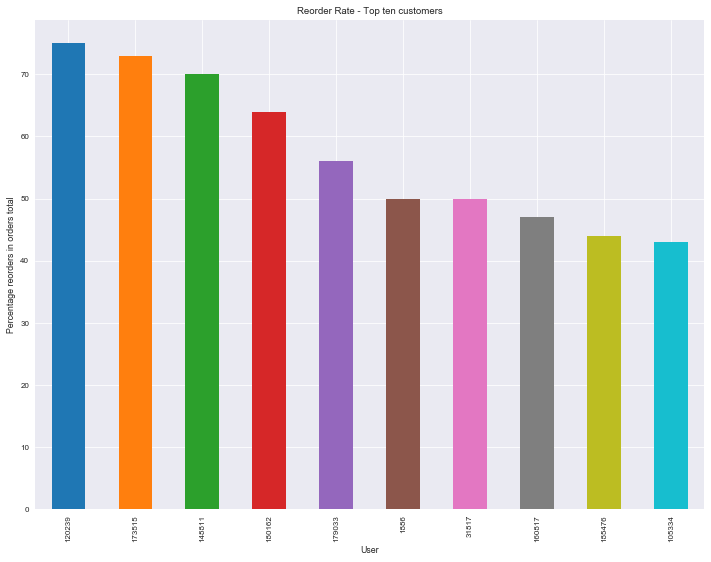

In [19]:
fig, ax = plt.subplots()
user_product_stats.sort_values(by="reorder_pct",ascending=False).head(n=10).sort_values(by="reorder_pct",ascending=False)['reorder_pct'].plot.bar();
ax.set_xticklabels(user_product_stats.sort_values(by="reorder_pct",ascending=False).head(n=10).index.values)
plt.title("Reorder Rate - Top ten customers")
plt.ylabel("Percentage reorders in orders total")
plt.xlabel("User")
plt.show()

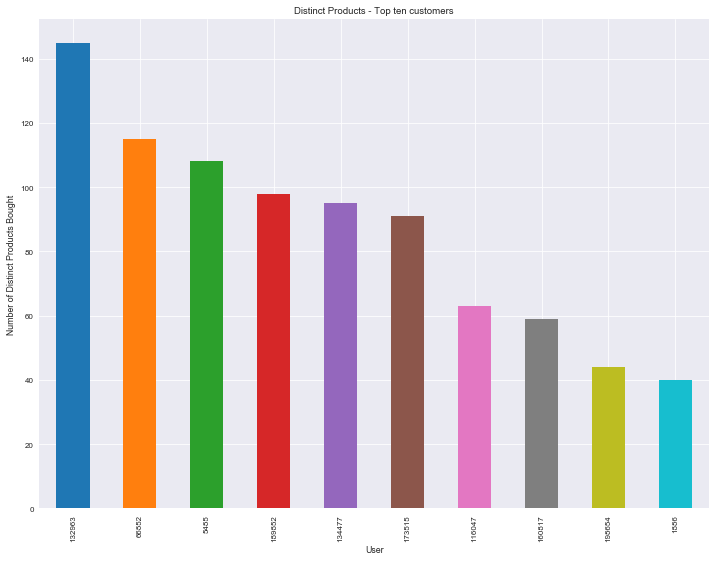

In [20]:
fig, ax = plt.subplots()
user_product_stats.sort_values(by="products_distinct",ascending=False).head(n=10).sort_values(by="products_distinct",ascending=False)['products_distinct'].plot.bar();
ax.set_xticklabels(user_product_stats.sort_values(by="products_distinct",ascending=False).head(n=10).index.values)
plt.title("Distinct Products - Top ten customers")
plt.ylabel("Number of Distinct Products Bought")
plt.xlabel("User")
plt.show()

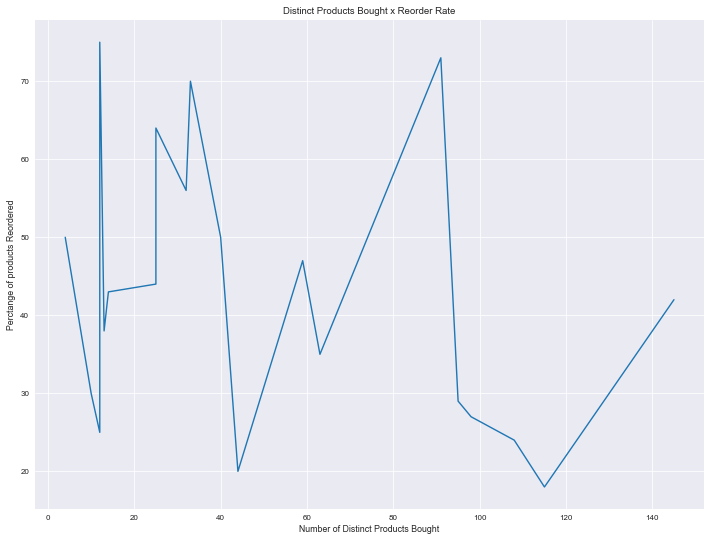

In [21]:
plt.title("Distinct Products Bought x Reorder Rate")
plt.ylabel("Perctange of products Reordered")
plt.xlabel("Number of Distinct Products Bought")
plt.plot(user_product_stats["products_distinct"], user_product_stats["reorder_pct"])

Lets pick a single user 132963

In [22]:
user_id = 132963
order_products_user = master_df.loc[master_df['user_id'] == user_id]
def get_element(my_list, position):
    return my_list[position]

unique_products_for_user = set(order_products_user["product_name"].values)
unique_products_for_user_count = len(unique_products_for_user)
print(unique_products_for_user_count)
#use groupby to group on order_id and then apply list to the product_name of every group
product_mix_df = pd.DataFrame(order_products_user.groupby("order_id")['product_name'].apply(list))
product_mix_df["product_count"] = product_mix_df.apply(lambda row: len(row["product_name"]), axis=1)
counter = unique_products_for_user_count
new_items=[]
old_items=[]
for mix in product_mix_df["product_name"].values:
    products_left = unique_products_for_user-set(mix)
    unique_in_this_mix = counter-len(products_left)
    counter = len(products_left)
    not_unique_in_this_mix = len(set(mix))-unique_in_this_mix
    unique_products_for_user = products_left
    new_items.append(unique_in_this_mix)
    old_items.append(not_unique_in_this_mix)

product_mix_df["new_orders"] = new_items
product_mix_df["reorders"] = old_items
#df.columns = ['product_mix', 'mix_size']
product_mix_df.head()
print(product_mix_df["new_orders"].sum())
product_mix_df.head()

145
145


,product_name,product_count,new_orders,reorders
order_id,,,,
54652,"[Premium Golden Seeded Hamburger Buns, Whole G...",8,8,0
136453,[Goldfish Cheddar Baked Snack Crackers Multi P...,5,4,1
311819,"[Organic Reduced Fat 2% Milk, Goldfish Cheddar...",10,8,2
361915,"[Indian Samosa Wrap, Eggo Homestyle Waffles, M...",10,9,1
446487,"[Organic Reduced Fat 2% Milk, Large Burrito Fl...",13,9,4


In [23]:
print("We would expect to see a trend where a new customer buys lots of different products, and as time goes on, they reorder their favourites")

We would expect to see a trend where a new customer buys lots of different products, and as time goes on, they reorder their favourites


,order_id,product_name,product_count,new_orders,reorders
0,54652,"[Premium Golden Seeded Hamburger Buns, Whole G...",8,8,0
1,136453,[Goldfish Cheddar Baked Snack Crackers Multi P...,5,4,1
2,311819,"[Organic Reduced Fat 2% Milk, Goldfish Cheddar...",10,8,2
3,361915,"[Indian Samosa Wrap, Eggo Homestyle Waffles, M...",10,9,1
4,446487,"[Organic Reduced Fat 2% Milk, Large Burrito Fl...",13,9,4


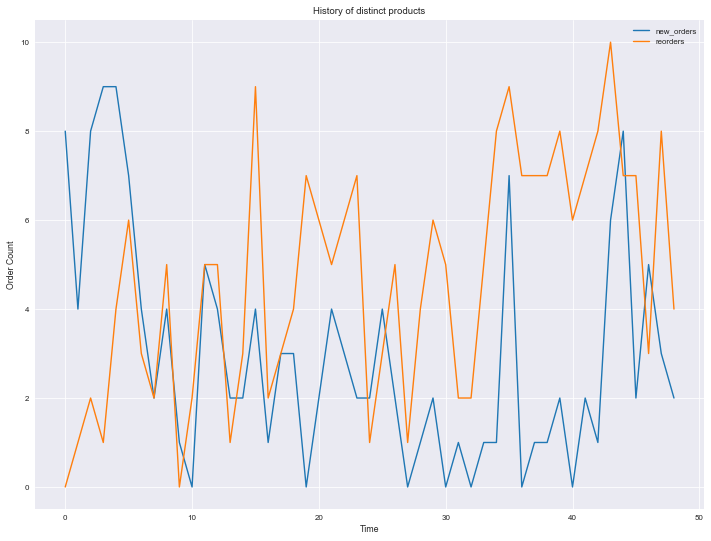

In [24]:
plt.title("History of distinct products")
plt.ylabel("Order Count")
plt.xlabel("Time")
plt.plot(product_mix_df.reset_index()["new_orders"])
plt.plot(product_mix_df.reset_index()["reorders"])
plt.legend()
product_mix_df.reset_index().head()

best fit line:
y = 4.52 + -0.06x
best fit line:
y = 2.12 + 0.11x


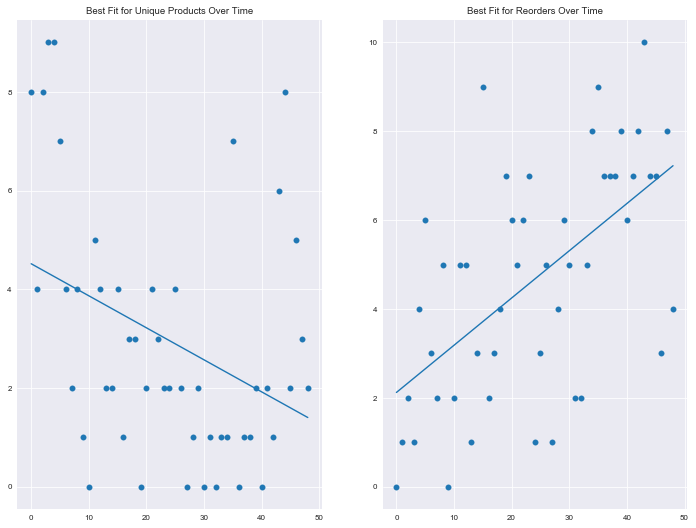

In [25]:


fig = plt.figure()
ax1 = fig.add_subplot(1, 2, 1)
X = product_mix_df.reset_index().index.values
Y = product_mix_df.reset_index()["new_orders"]
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.title("Best Fit for Unique Products Over Time")
plt.plot(X, yfit)



ax2 = fig.add_subplot(1, 2, 2)
Y = product_mix_df.reset_index()["reorders"]
a, b = best_fit(X, Y)

# plot points and fit line
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.title("Best Fit for Reorders Over Time")
plt.plot(X, yfit)